# **Part 1: Data pre-processing and exploration**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./interview_dataset.csv')
print(df.columns)
print(df.shape)

Index(['text', 'star_rating', 'helpful', 'id'], dtype='object')
(10716, 4)


First let us find the distribution of rating scores to determine what star rating should be considered as having a positive sentiment versus a negative sentiment

<BarContainer object of 5 artists>

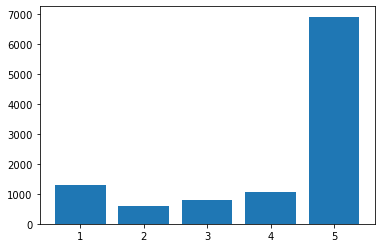

In [3]:
stars = [sum(df["star_rating"]==i) for i in range(1,6)]

plt.bar(["1","2","3","4","5"], stars)

As we can see, the review dataset is heavily skewed towards 5-star ratings. To save time and avoid having to adjust our calculations of precision, recall, and accuracy to account for skewness in the dataset, let us define the classifier to simply detect whether the review is 5-star or below. 

*Rating by product:*
Next, let us verify whether the average review per product does not vary too significantly.

In [4]:
products = df["id"].value_counts()

productRating = []
for p in products.index:
    productStars = [sum((df["star_rating"]==i) & (df["id"]==p)) for i in range(1,6)]
    numReviews = sum(df["id"]==p)
    productRating.append(np.divide(productStars, numReviews))

In [5]:
# Get percentage 5 star ratings per product
fiveStars = [productRating[i][4] for i in range(len(products.index))] 
print("5 star ratings (%)")
print("Mean: " + str(np.round(np.mean(fiveStars),4)))
print("Standard Deviation: " + str(np.round(np.std(fiveStars),4)))

5 star ratings (%)
Mean: 0.6378
Standard Deviation: 0.1142


# **Part 2: Text Processing with Long Short-Term Memory in TensorFlow**

Let us implement a simple LSTM network to process the Amazon Review data and predict whether the review will be a 5-star rating or below. I could likely reach higher accuracy, precision, and recall scores with an attention / transformer network but since the goal of this assignment is not to simply implement the latest technology, I will go with a simpler LSTM model.

In [6]:
# pip install tensorflow <-- try this if module not available

import os
import re
import string

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(tf.__version__)

2.4.1


For better results, remove punctuation and capitalization

In [7]:
def clean_text(r):
    del_dict = {special_char: "" for special_char in string.punctuation}
    del_dict[" "] = " "
    table = str.maketrans(del_dict)
    r1 = r.translate(table)
    textArray = r1.split()
    r2 = " ".join([l for l in textArray if (not l.isdigit() and (not l.isdigit() and len(l) > 2))])
    return r2.lower()

In [8]:
textAsNP = df["text"].to_numpy()
text = [textAsNP[r] for r in range(len(textAsNP))]

print("Text before cleaning: " + str(text[0]))
print("Text after cleaning: " + str(clean_text(text[0])))

Text before cleaning: This item doesn’t have a lot number or expiration date. My face has broken out ever since using this. I didn’t put two and two together until I got a new one from my dermotologist. See photo. The one that is from my dermotologist has a lot # and expiration date.
Text after cleaning: this item doesn’t have lot number expiration date face has broken out ever since using this didn’t put two and two together until got new one from dermotologist see photo the one that from dermotologist has lot and expiration date


<AxesSubplot:>

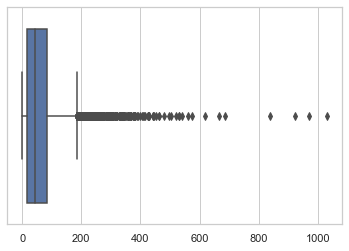

In [9]:
import seaborn as sns

numWords = [len(str(text[x]).split()) for x in range(len(text))]
sns.set(style="whitegrid")
sns.boxplot(x=numWords)

Since the vast majority of the reviews are less than 200 words, let us trim the dataset to only include relatively short reviews (200 words or less) to save on computational time.

In [10]:
trimmed = [(numWords[n] < 250) & (numWords[n] > 20) for n in range(len(numWords))]
df_new = df[trimmed]
len(df_new)

7223

In [11]:
def fivestar(rating):
    if rating == 5:
        return 1
    else:
        return 0

In [12]:
textAsNP = df_new["text"].to_numpy()
textRaw = [textAsNP[r] for r in range(len(textAsNP))] 
X = [clean_text(textRaw[r]) for r in range(len(textAsNP[1:7000]))] # data
X_test = [clean_text(textRaw[r+7000]) for r in range(len(textAsNP[7000:-1]))] # data

ratingAsNP = df_new["star_rating"].to_numpy()
rating = [ratingAsNP[r] for r in range(len(ratingAsNP))]
y = [fivestar(rating[r]) for r in range(len(rating[1:7000]))] # label
y_test = [fivestar(rating[r+7000]) for r in range(len(rating[7000:-1]))] # label

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y, random_state=0)

print("Training set size: " + str(len(X_train)) + " samples")
print("Validation set size: " + str(len(X_valid)) + " samples")
print("Test set size: " + str(len(X_test)) + " samples")

Training set size: 6649 samples
Validation set size: 350 samples
Test set size: 222 samples


In [14]:
num_words = 50000

tokenizer = Tokenizer(num_words = num_words, oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [15]:
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test = np.array(tokenizer.texts_to_sequences(X_test))

x_train = pad_sequences(x_train, padding='post', maxlen=250)
x_valid = pad_sequences(x_valid, padding='post', maxlen=250)
x_test = pad_sequences(x_test, padding='post', maxlen=250)

train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(y_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

from collections import Counter
print('Train set size: '+ str(len(x_train)))
print('Label distribution: 1: '+ str(Counter(train_labels)[1]) + ', 0: ' + str(Counter(train_labels)[0]))

print('Validation set size: '+ str(len(x_valid)))
print('Label distribution: 1: '+ str(Counter(valid_labels)[1]) + ', 0: ' + str(Counter(valid_labels)[0]))

print('Test set size: '+str(len(x_test)))
print('Label distribution: 1: '+ str(Counter(test_labels)[1]) + ', 0: ' + str(Counter(test_labels)[0]))

Train set size: 6649
Label distribution: 1: 3879, 0: 2770
Validation set size: 350
Label distribution: 1: 204, 0: 146
Test set size: 222
Label distribution: 1: 135, 0: 87


<ipython-input-15-1e59048b270b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train = np.array(tokenizer.texts_to_sequences(X_train))
<ipython-input-15-1e59048b270b>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
<ipython-input-15-1e59048b270b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when c

In [18]:
i = 0
print('Train dataset: First five examples')
for v, l in train_ds:
    i += 1
    print(v, l)
    if i == 5:
        break
i = 0
print('Validation dataset: First five examples')
for v, l in valid_ds:
    i += 1
    print(v, l)
    if i == 5:
        break
i = 0
print('Test dataset: First five examples')
for v, l in test_ds:
    i += 1
    print(v, l)
    if i == 5:
        break

Train dataset: First five examples
tf.Tensor(
[   4 1575   14  118  162    2  123    3  438   45   58  131   14  660
    3  225   52  551  367 1576  442 4278   11  391   43   52  551  646
   99  263   59 1914   41  392 4279    3 5063    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

Now that the datasets are created, let's build the Long Short-Term Memory (LSTM) model with keras. LSTM is a network with a recurrent neural network architecture. It is best suited for processing long sequences of data, and is especially useful when there are dependencies between information that is spaced out in the sequence. For example, if I were to feed the LSTM network the sequence: "It is not true that I like this product.", the LSTM model would likely store the word "not", because this negates the later part "I like this product" and makes the overall sentiment negative.

In [19]:
max_features = num_words
embedding_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=250, embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer = regularizers.l2(0.005), bias_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation = "relu", kernel_regularizer = regularizers.l2(0.001), bias_regularizer = regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation = "relu", kernel_regularizer = regularizers.l2(0.001), bias_regularizer = regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 250, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 250, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2048512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [20]:
## Only run this when training the model!

# history = model.fit(train_ds.shuffle(1000).batch(500), epochs=15, validation_data=valid_ds.batch(500), verbose=1)

Epoch 1/15
14/14 [==============================] - 8s 346ms/step - loss: 4.3815 - binary_accuracy: 0.5735 - val_loss: 2.4597 - val_binary_accuracy: 0.5829
Epoch 2/15
14/14 [==============================] - 4s 308ms/step - loss: 2.1042 - binary_accuracy: 0.5878 - val_loss: 1.3127 - val_binary_accuracy: 0.5829
Epoch 3/15
14/14 [==============================] - 4s 311ms/step - loss: 1.1900 - binary_accuracy: 0.5882 - val_loss: 0.9389 - val_binary_accuracy: 0.5829
Epoch 4/15
14/14 [==============================] - 4s 313ms/step - loss: 0.9042 - binary_accuracy: 0.5834 - val_loss: 0.8127 - val_binary_accuracy: 0.5829
Epoch 5/15
14/14 [==============================] - 4s 317ms/step - loss: 0.7881 - binary_accuracy: 0.5892 - val_loss: 0.7430 - val_binary_accuracy: 0.5829
Epoch 6/15
14/14 [==============================] - 4s 318ms/step - loss: 0.7257 - binary_accuracy: 0.6473 - val_loss: 0.7054 - val_binary_accuracy: 0.7771
Epoch 7/15
14/14 [==============================] - 5s 330ms/ste

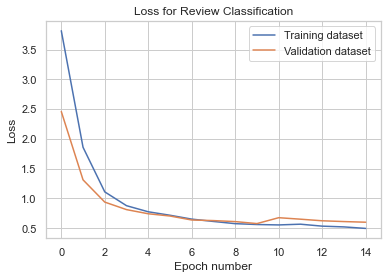

In [28]:
plt.plot(history.history['loss'], label = 'Training dataset')
plt.plot(history.history['val_loss'], label = 'Validation dataset')
plt.title('Loss for Review Classification')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")
plt.show()

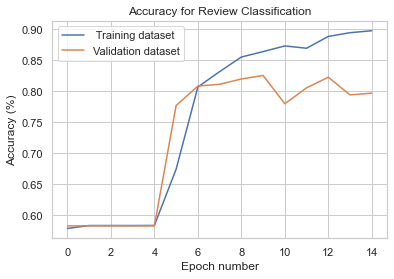

In [29]:
plt.plot(history.history['binary_accuracy'], label=' Training dataset')
plt.plot(history.history['val_binary_accuracy'], label='Validation dataset')
plt.title('Accuracy for Review Classification')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch number')
plt.legend(loc="upper left")
plt.show()

In [30]:
valid_predict = model.predict(x_valid)
#print(valid_predict[:])

In [25]:
## Save model
model.save('.\\LSTM_model.h5') 
json_string = tokenizer.to_json()

import json
with open('.\\tokenizer.json', 'w') as ofile:
    json.dump(json_string, ofile)

In [26]:
## Load model
new_model = tf.keras.models.load_model('.\\LSTM_model.h5')
new_model.summary()

with open('.\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 250, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 250, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2048512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

## Part 3: Results

As you can see, overall accuracy of the LSTM model was approximately 75%, which is obviously far from ideal for a simple sentiment classification problem. With some additional time I would have been able to further increase the accuracy through hyperparameter tuning and tweaking. However, I hope this served as a good overview to my problem-solving approach and data exploration process.

In [27]:
## test on testing dataset
predictions = new_model.predict(x_test)
predictions[predictions >= 0.56] = 1
predictions[predictions < 0.56] = 0

print(classification_report(test_labels,predictions,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70        87
           1       0.82      0.73      0.78       135

    accuracy                           0.74       222
   macro avg       0.74      0.75      0.74       222
weighted avg       0.76      0.74      0.75       222

